In [1]:
import sys

sys.path.append("../")
sys.path.append("../src")

from src.deepqlearning import DeepQlearning, NeuralNetwork
from src.agent import Player
import matplotlib.pyplot as plt

# Set up training

In [2]:
Q = DeepQlearning(model=NeuralNetwork(), initial_exploration_factor=0.8)
Q.training(n_training_game=1000, batch_size=32)
Q.play()

100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


# Analyze training

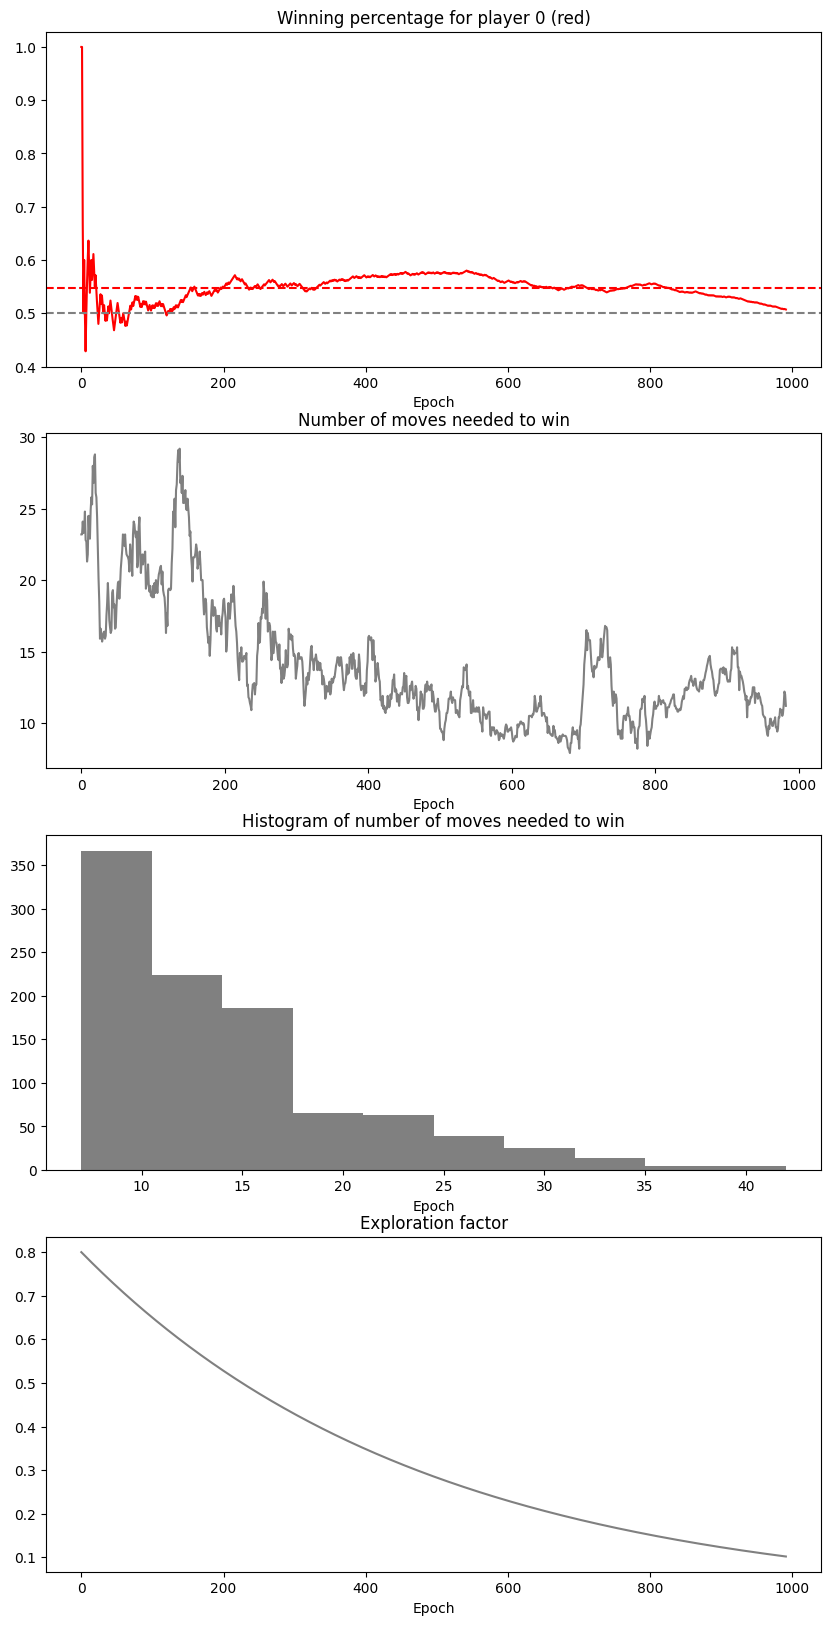

In [3]:
Q.plot_training_stats()
plt.show()

# Look at a game

In [4]:
Q.play()

In [5]:
player = Player(get_action=lambda state: Q.get_action(state))